# Exploring the dataset

In [1]:
import os
import json
import zipfile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.cluster import KMeans

## Extracting the created dataset

In [2]:
dataset_path = "./data/dataset"

# extracting dataset
with zipfile.ZipFile("./dataset.zip", 'r') as f:
    f.extractall(dataset_path)

## Loading metadata

The metadata is a JSON file with a number of key-value pairs. The root keys are some sort of image ids (which the VGG annotator generates) and the values are:
- filename: the name of the file with extension
- size: the size of the image, in bytes.
- regions: this is an array consisting of the bounding boxes
    - shape_attributes: how the bbox is defined, could be a circle, rectangle, etc. It consists of `x` and `y` coordinates, and `height` and `width` of the box, if the bbox is a rectangle.
    - region_attributes: this contained the label for the region, in this case, one of `mask`, `hardhat`, `boots`, `vest`, and some metadata which the dataset maker can add, like if the image is blurry, has good illumination, etc
- file_attributes: extra meta data of the image file, like the URL, caption and if it was from public domain, etc.


In [3]:
with open(os.path.join(dataset_path, "meta.json")) as f:
    meta = json.load(f)

In [4]:
# looking at the first key-value pair in the metadata

image_key = list(meta.keys())[0]
img_meta = meta[image_key]
print(json.dumps({image_key: img_meta}, indent=2))

{
  "img1.jpg54876": {
    "filename": "img1.jpg",
    "size": 54876,
    "regions": [
      {
        "shape_attributes": {
          "name": "rect",
          "x": 323,
          "y": 240,
          "width": 174,
          "height": 170
        },
        "region_attributes": {
          "class": "mask"
        }
      },
      {
        "shape_attributes": {
          "name": "rect",
          "x": 257,
          "y": 19,
          "width": 281,
          "height": 167
        },
        "region_attributes": {
          "class": "hardhat"
        }
      }
    ],
    "file_attributes": {
      "caption": "",
      "public_domain": "no",
      "image_url": ""
    }
  }
}


## Analysis

In [5]:
# some helper functions

def get_bboxes(img_meta):
    """
    Gets the bounding box info from the metadata of the image.
    """
    bboxes = list()
    for bbox in img_meta["regions"]:
        shape_attrib = bbox["shape_attributes"]
        bboxes.append((
            shape_attrib["x"],
            shape_attrib["y"],
            shape_attrib["width"],
            shape_attrib["height"]
        ))
    return bboxes

def display_image(img_meta, figsize=(10, 15)):
    """
    Displays an image along with the bounding boxes.
    """
    bboxes = get_bboxes(img_meta)
    img_path = os.path.join(dataset_path, "images", img_meta["filename"])

    img = Image.open(img_path)
    fix, ax = plt.subplots(1, figsize=figsize)

    ax.imshow(img)

    for bbox in bboxes:
        x, y, width, height = bbox
        ax.add_patch(
            patches.Rectangle(
                (x, y),
                width,
                height,
                linewidth=3,
                edgecolor='r', 
                facecolor='none'
            )
        )
    
    plt.axis("off")
    plt.show()

def calc_bbox_ratios(img_meta):
    """
    Calculates the bbox_width:image_width and bbox_height:image_height ratios,
    given the metadata of an image.
    """
    ratios = []
    img_width, img_height = Image.open(
        os.path.join(dataset_path, "images", img_meta["filename"])
    ).size

    for bbox in get_bboxes(img_meta):
        x, y, width, height = bbox
        ratios.append((width / img_width, height / img_height))

    return ratios

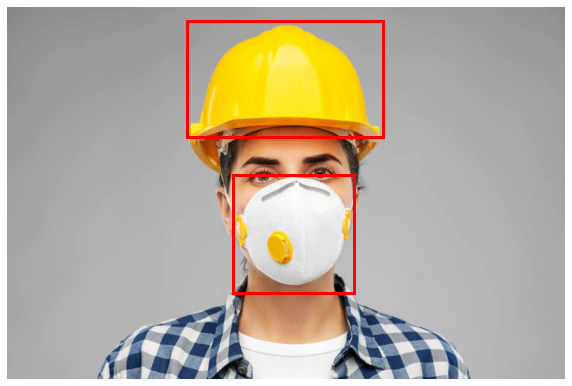

In [6]:
# displaying one of the images in the dataset
display_image(meta[image_key])

### Calculating the ratios of the bounding boxes and plotting

In [7]:
# calculating ratios for all images
bbox_ratios = []
for img_meta in meta.values():
    bbox_ratios.extend(calc_bbox_ratios(img_meta))
bbox_ratios = np.array(bbox_ratios)

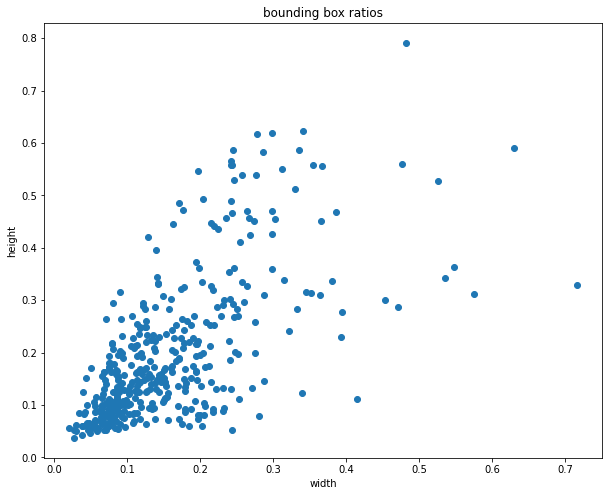

In [8]:
# plotting a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(bbox_ratios[:, 0], bbox_ratios[:, 1])
plt.xlabel("width")
plt.ylabel("height")
plt.title("bounding box ratios")
plt.show()

### Applying KMeans to find optimal number of clusters

Using the elbow method to find the optimal number of clusters:

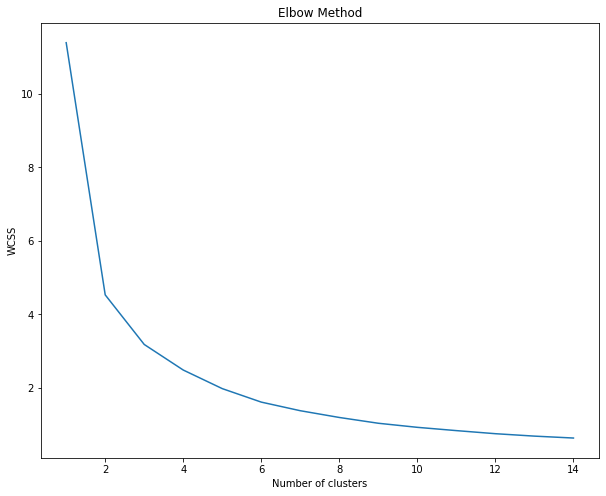

In [9]:
wcss = []
for c in range(1, 15):
    kmeans = KMeans(
        n_clusters=c,
        init='k-means++',
        max_iter=300,
        n_init=10,
        random_state=0
    )
    kmeans.fit(bbox_ratios)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 8))
plt.plot(range(1, 15), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Plotting KMeans results
Looks like an optimal number of clusters is 4. So lets plot it.

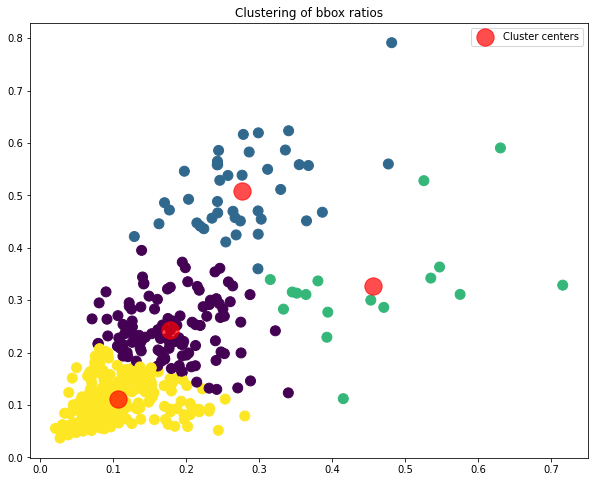

In [10]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(bbox_ratios)

plt.figure(figsize=(10, 8))
plt.scatter(bbox_ratios[:,0], bbox_ratios[:,1], c=pred_y, s=100)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, alpha=.7, c='r', label="Cluster centers")
plt.title('Clustering of bbox ratios')
plt.legend()
plt.show()